# ArcFace Explained

This notebook implements ArcFace algorithm introduced in https://arxiv.org/abs/1801.07698 in pytorch with step by step explanations.
Also recreates an experiment to visualize distribution of embeddings on the MNIST dataset. Fastai library is used for training

In [1]:
from fastai.vision.all import *
from tqdm.notebook import tqdm

In [2]:
emb_size = 3
output_classes = 10
batch_size = 1 # for illustration only

## How does it work?

#### Consider a typical classifier you'd put as a final layer in your network

In [3]:
classifier = nn.Linear(emb_size, output_classes, bias=False)
W = classifier.weight.T # nn.Linear keeps it output_classes x emb_size but it's easier to think about it the other way round

#### If we set the bias to False all it does is a single matrix multiplication of embedings by the layer weights. That is:

In [4]:
x = torch.rand((batch_size, emb_size))
y1 = classifier(x)
y2 = x @ W
(y1==y2).all()

tensor(True)

#### Another way to look at it is that for each embedding we compute it's dot product with weight columns corresponding to every output class

In [5]:
y04 = torch.dot(x[0], W[:,4])
y04, y1[0][4]

(tensor(0.3678, grad_fn=<DotBackward>),
 tensor(0.3678, grad_fn=<SelectBackward>))

#### Now imagine that both embeddings and weight columns are vectors of length 1. 
Taking their dot product is the same as calculating [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)
And with unit vectors it's just cosine of the angle between them.

In [6]:
x = F.normalize(x)
W = F.normalize(W, dim=0)

outputs = x @ W
sim04 = F.cosine_similarity(x[0], W[:,4], dim=0)
sim04, outputs[0][4]

(tensor(0.6225, grad_fn=<DivBackward0>),
 tensor(0.6225, grad_fn=<SelectBackward>))

#### Since our outputs are now cosines of angles, we can reverse it with arccos and get the actual angles.

In [7]:
angle_output = outputs.arccos()
angle_output[0]

tensor([1.8792, 0.9283, 2.3826, 1.1615, 0.8988, 1.2295, 0.6665, 2.3790, 0.9056,
        1.7627], grad_fn=<SelectBackward>)

#### And in degrees:

In [8]:
angle_output[0].rad2deg()

tensor([107.6717,  53.1897, 136.5138,  66.5478,  51.5002,  70.4454,  38.1864,
        136.3091,  51.8864, 100.9960], grad_fn=<Rad2DegBackward>)

#### The smaller the angle the closer the cosine is to 1 and the higher activation when computing the Cross Entropy Loss.

### With all that out of the way, here is what the ArcFace algorithm does:
1. Normalize the embeddings and weights
2. Calculate the dot products
3. Calculate the angles with arccos
4. **Add a constant factor m to the angle corresponding to the ground truth label**
5. Turn angles back to cosines
6. Use cross entropy on the new cosine values to calculate loss

The only part left to explain is the step 4. What we are doing is making it harder for the network to train. Similar to what dropout or weight decay does, but here we are extra mean and only shift the activation the network want's to predict. The idea is that in order for the activation to win at softmax it not only needs to be slightly better than the second best. It needs to be better by more than the angle we shifted by adding **m** (the default 0.4 corresponds to about 20 degrees). We add a margin to one of the angles, hence the 'Additive Angular Margin
Loss' in the title of the paper.

The intended consequence of that is that we force embeddings to cluster closer together within class and further apart across other classes.

*Side note: there is another step in the paper that scales all the vectors by a constant factor at the end. This doesn't change the ordering of logits but changes their relative values after softmax. I didn't see it help on this dataset but it might be a hyperparameter worth tweaking on other tasks.*

## Sample Implementation ##

In [9]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, emb_size, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        # Step 1:
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        # Step 2:
        return x_norm @ W_norm
    
def arcface_loss(cosine, targ, m=.4):
    # this prevents nan when a value slightly crosses 1.0 due to numerical error
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    # Step 3:
    arcosine = cosine.arccos()
    # Step 4:
    arcosine += F.one_hot(targ, num_classes = output_classes) * m
    # Step 5:
    cosine2 = arcosine.cos()
    # Step 6:
    return F.cross_entropy(cosine2, targ)

## Test it on MNIST, using fastai for training

#### The model:

In [10]:
# a very basic network, just four strided convolutions, batch norm and ReLu
class SimpleConv(nn.Module):
    def __init__(self, classifier):
        super().__init__()
        ch_in=[3,6,12,24]
        convs = [ConvLayer(c, c*2, stride=2) for c in ch_in]
        convs += [AdaptiveAvgPool(), Flatten(), nn.Linear(48, emb_size)]
        self.convs = nn.Sequential(*convs)
        self.classifier = classifier
        
    def get_embs(self, x):
        return self.convs(x)
    
    def forward(self, x):
        x = self.get_embs(x)
        x = self.classifier(x)
        return x


In [11]:
# helper method to extract all embedings from a data loader
def get_embs(model, dl):
    embs = []
    ys = []
    for bx,by in tqdm(dl):
        with torch.no_grad():
            embs.append(model.get_embs(bx))
            ys.append(by)
    embs = torch.cat(embs)
    embs = embs / embs.norm(p=2,dim=1)[:,None]
    ys = torch.cat(ys)
    return embs,ys

# helper to plot embeddings in 3D
def plot_embs(embs, ys, ax):
    #ax.axis('off')
    for k in range(10):
        e = embs[ys==k].cpu()
        ax.scatter(e[:,0], e[:,1], e[:,2], s=4, alpha=.2)   


* Three lines of code to create a dataloader and train our model. Don't you love [fast.ai](fast.ai)

In [12]:
dls =ImageDataLoaders.from_folder(untar_data(URLs.MNIST), train='training', valid='testing', num_workers=8)
learn = Learner(dls, SimpleConv(ArcFaceClassifier(3,10)), metrics=accuracy, loss_func = arcface_loss)

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.674659,1.649024,0.916100,01:36
1,1.606831,1.596204,0.945400,01:33
2,1.588369,1.576656,0.948700,01:32
3,1.568906,1.562239,0.948100,01:33
4,1.561106,1.560540,0.944100,01:36


In [13]:
embs_arcface, ys_arcface  = get_embs(learn.model.eval(), dls.valid)

  0%|          | 0/157 [00:00<?, ?it/s]

#### Use a standard nn.Linear and cross entropy for comparison

In [14]:
learn = Learner(dls, SimpleConv(nn.Linear(3,10)), metrics=accuracy)
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.268605,0.206510,0.942600,01:33
1,0.138753,0.100702,0.971100,01:34
2,0.091579,0.078673,0.978400,01:32
3,0.062922,0.056491,0.983900,01:33
4,0.042850,0.053658,0.984700,01:34


In [15]:
embs_softmax, ys_softmax  = get_embs(learn.model.eval(), dls.valid)

  0%|          | 0/157 [00:00<?, ?it/s]

In [16]:
### You should be able to see a tighter clustering of embeddings on the left

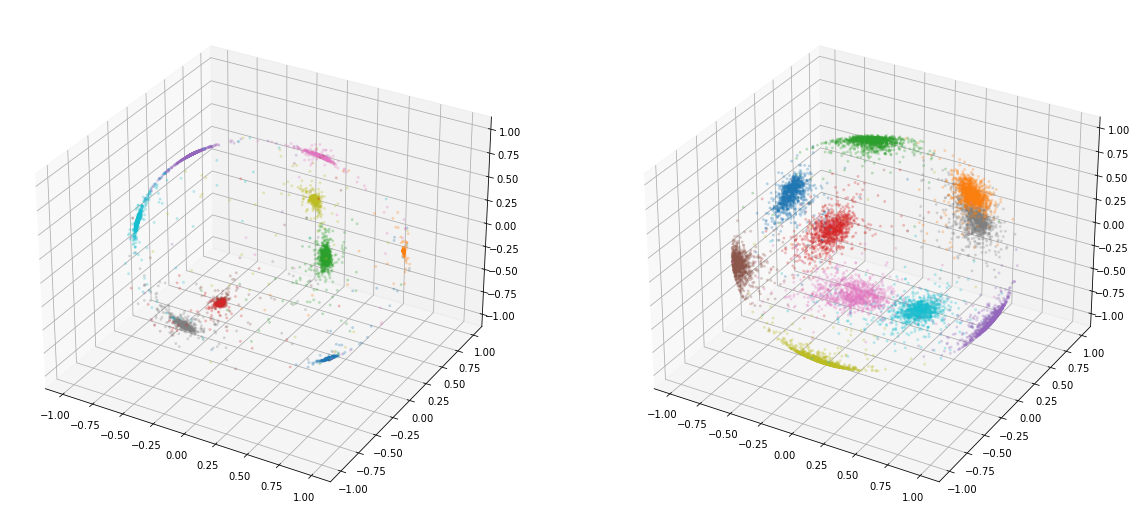

In [17]:
_,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10), subplot_kw={'projection':'3d'})
plot_embs(embs_arcface, ys_arcface, ax1)
plot_embs(embs_softmax, ys_softmax, ax2)

plt.show()